In [3]:
# Task 3: Understanding Generative Adversarial Network Dynamics
# MNIST GAN Implementation

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid
import os

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


In [4]:

# ============================================================================
# 1. DATASET SETUP
# ============================================================================

print("Setting up MNIST dataset...")

# Define transforms: normalize to [-1, 1] range
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=0.5, std=0.5)  # Maps [0,1] to [-1,1]
])

# Load MNIST dataset
mnist_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

# Create DataLoader
batch_size = 64
dataloader = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True)

print(f"Dataset loaded: {len(mnist_dataset)} samples")
print(f"Batch size: {batch_size}")
print(f"Number of batches: {len(dataloader)}")


Setting up MNIST dataset...


100%|██████████| 9.91M/9.91M [00:00<00:00, 17.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 485kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.46MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.36MB/s]

Dataset loaded: 60000 samples
Batch size: 64
Number of batches: 938


In [5]:

# ============================================================================
# 2. MODEL ARCHITECTURE
# ============================================================================

class Generator(nn.Module):
    """
    Generator network: takes noise vector z and produces 28x28 images
    Architecture: 100 -> 256 -> 512 -> 784 (reshaped to 28x28)
    """
    def __init__(self, noise_dim=100, img_size=784):
        super(Generator, self).__init__()
        self.img_size = img_size

        self.model = nn.Sequential(
            # First layer: 100 -> 256
            nn.Linear(noise_dim, 256),
            nn.ReLU(True),

            # Second layer: 256 -> 512
            nn.Linear(256, 512),
            nn.ReLU(True),

            # Output layer: 512 -> 784
            nn.Linear(512, img_size),
            nn.Tanh()  # Output in [-1, 1] range
        )

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        """Initialize weights with normal distribution (std=0.02)"""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight.data, 0.0, 0.02)
                nn.init.constant_(m.bias.data, 0)

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), 1, 28, 28)  # Reshape to (batch_size, 1, 28, 28)
        return img

class Discriminator(nn.Module):
    """
    Discriminator network: takes 28x28 images and outputs probability of being real
    Architecture: 784 -> 256 -> 256 -> 1
    """
    def __init__(self, img_size=784):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            # First layer: 784 -> 256
            nn.Linear(img_size, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),

            # Second layer: 256 -> 256
            nn.Linear(256, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),

            # Output layer: 256 -> 1
            nn.Linear(256, 1),
            nn.Sigmoid()  # Output probability
        )

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        """Initialize weights with normal distribution (std=0.02)"""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight.data, 0.0, 0.02)
                nn.init.constant_(m.bias.data, 0)

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)  # Flatten to (batch_size, 784)
        validity = self.model(img_flat)
        return validity

# Initialize networks
noise_dim = 100
generator = Generator(noise_dim).to(device)
discriminator = Discriminator().to(device)

print("Generator architecture:")
print(generator)
print(f"\nGenerator parameters: {sum(p.numel() for p in generator.parameters())}")

print("\nDiscriminator architecture:")
print(discriminator)
print(f"Discriminator parameters: {sum(p.numel() for p in discriminator.parameters())}")


Generator architecture:
Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=512, out_features=784, bias=True)
    (5): Tanh()
  )
)

Generator parameters: 559632

Discriminator architecture:
Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=256, out_features=1, bias=True)
    (7): Sigmoid()
  )
)
Discriminator parameters: 267009


In [6]:

# ============================================================================
# 3. TRAINING SETUP
# ============================================================================

# Loss function
criterion = nn.BCELoss()

# Optimizers with specified hyperparameters
lr = 2e-4  # 2 × 10^-4
beta1 = 0.5
beta2 = 0.999

optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, beta2))

print(f"Learning rate: {lr}")
print(f"Adam betas: ({beta1}, {beta2})")

# Training parameters
num_epochs = 20
print_interval = 100  # Print every 100 batches
save_interval = 5     # Save sample images every 5 epochs

# Fixed noise for monitoring progress
fixed_noise = torch.randn(25, noise_dim, device=device)  # 5x5 grid

# Lists to store losses
G_losses = []
D_losses = []
D_real_scores = []
D_fake_scores = []

# Label smoothing parameter
label_smoothing = True
real_label_value = 0.9 if label_smoothing else 1.0

print(f"Training for {num_epochs} epochs")
print(f"Label smoothing: {label_smoothing} (real label value: {real_label_value})")


Learning rate: 0.0002
Adam betas: (0.5, 0.999)
Training for 20 epochs
Label smoothing: True (real label value: 0.9)


Starting training...
------------------------------------------------------------
Epoch [1/20], Batch [1/938], D_loss: 1.4034, G_loss: 0.6933, D(real): 0.4895, D(fake): 0.5000
Epoch [1/20], Batch [101/938], D_loss: 1.3757, G_loss: 0.7307, D(real): 0.5483, D(fake): 0.5276
Epoch [1/20], Batch [201/938], D_loss: 1.0026, G_loss: 1.0623, D(real): 0.7453, D(fake): 0.4402
Epoch [1/20], Batch [301/938], D_loss: 0.8491, G_loss: 1.2520, D(real): 0.7110, D(fake): 0.2920
Epoch [1/20], Batch [401/938], D_loss: 0.6690, G_loss: 1.5508, D(real): 0.8692, D(fake): 0.2467
Epoch [1/20], Batch [501/938], D_loss: 0.6160, G_loss: 2.3659, D(real): 0.9076, D(fake): 0.2175
Epoch [1/20], Batch [601/938], D_loss: 0.5435, G_loss: 3.0156, D(real): 0.9151, D(fake): 0.1414
Epoch [1/20], Batch [701/938], D_loss: 0.5248, G_loss: 2.5945, D(real): 0.7866, D(fake): 0.0694
Epoch [1/20], Batch [801/938], D_loss: 0.4584, G_loss: 3.2042, D(real): 0.9071, D(fake): 0.0679
Epoch [1/20], Batch [901/938], D_loss: 0.5782, G_loss: 2

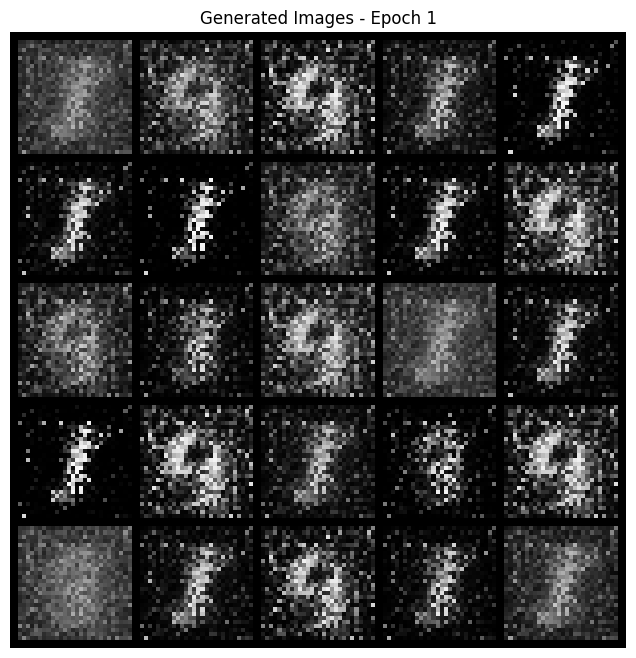

Epoch [1/20] completed - Avg D_loss: 1.9659, Avg G_loss: 0.7697
------------------------------------------------------------
Epoch [2/20], Batch [1/938], D_loss: 0.7142, G_loss: 3.4460, D(real): 0.8322, D(fake): 0.2449
Epoch [2/20], Batch [101/938], D_loss: 0.7636, G_loss: 1.6379, D(real): 0.6593, D(fake): 0.0687
Epoch [2/20], Batch [201/938], D_loss: 0.6525, G_loss: 3.1439, D(real): 0.7979, D(fake): 0.1403
Epoch [2/20], Batch [301/938], D_loss: 0.5560, G_loss: 3.6866, D(real): 0.8235, D(fake): 0.1049
Epoch [2/20], Batch [401/938], D_loss: 0.5081, G_loss: 4.5343, D(real): 0.8801, D(fake): 0.1067
Epoch [2/20], Batch [501/938], D_loss: 0.4541, G_loss: 4.1813, D(real): 0.8348, D(fake): 0.0471
Epoch [2/20], Batch [601/938], D_loss: 0.8508, G_loss: 2.0949, D(real): 0.5830, D(fake): 0.0467
Epoch [2/20], Batch [701/938], D_loss: 0.6796, G_loss: 2.4499, D(real): 0.7584, D(fake): 0.1556
Epoch [2/20], Batch [801/938], D_loss: 0.7742, G_loss: 3.8664, D(real): 0.8670, D(fake): 0.2834
Epoch [2/20],

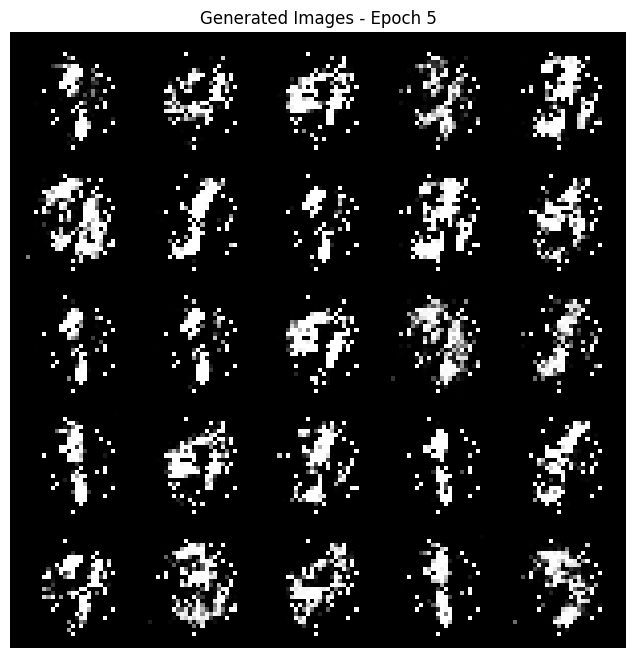

Epoch [5/20] completed - Avg D_loss: 3.6883, Avg G_loss: 0.5394
------------------------------------------------------------
Epoch [6/20], Batch [1/938], D_loss: 0.5335, G_loss: 3.0490, D(real): 0.7941, D(fake): 0.0446
Epoch [6/20], Batch [101/938], D_loss: 0.3622, G_loss: 5.6081, D(real): 0.9128, D(fake): 0.0063
Epoch [6/20], Batch [201/938], D_loss: 0.3351, G_loss: 7.6263, D(real): 0.9063, D(fake): 0.0023
Epoch [6/20], Batch [301/938], D_loss: 0.3327, G_loss: 8.8296, D(real): 0.9057, D(fake): 0.0006
Epoch [6/20], Batch [401/938], D_loss: 0.3324, G_loss: 8.5902, D(real): 0.8985, D(fake): 0.0007
Epoch [6/20], Batch [501/938], D_loss: 0.3344, G_loss: 8.8168, D(real): 0.9016, D(fake): 0.0008
Epoch [6/20], Batch [601/938], D_loss: 0.3362, G_loss: 7.0969, D(real): 0.8937, D(fake): 0.0028
Epoch [6/20], Batch [701/938], D_loss: 0.3914, G_loss: 5.8792, D(real): 0.8602, D(fake): 0.0165
Epoch [6/20], Batch [801/938], D_loss: 0.3931, G_loss: 5.4039, D(real): 0.8803, D(fake): 0.0344
Epoch [6/20],

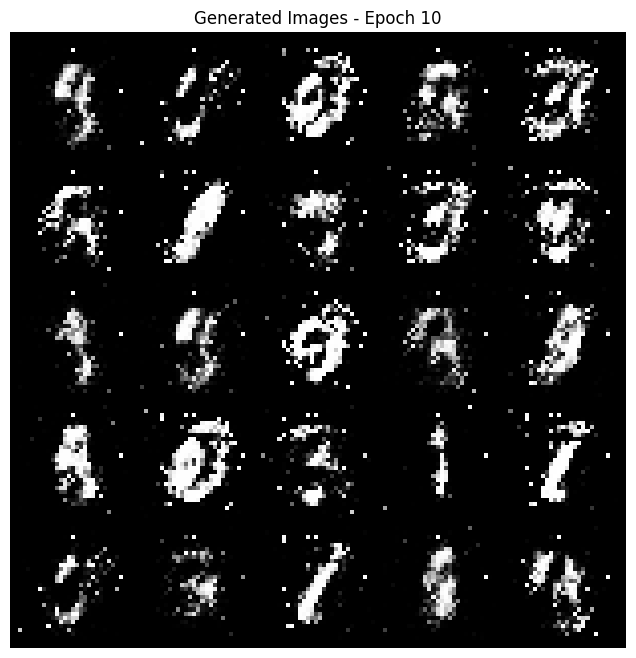

Epoch [10/20] completed - Avg D_loss: 2.1082, Avg G_loss: 0.8549
------------------------------------------------------------
Epoch [11/20], Batch [1/938], D_loss: 0.8886, G_loss: 2.1170, D(real): 0.7783, D(fake): 0.3196
Epoch [11/20], Batch [101/938], D_loss: 0.8681, G_loss: 1.9232, D(real): 0.7412, D(fake): 0.2573
Epoch [11/20], Batch [201/938], D_loss: 0.9028, G_loss: 2.0881, D(real): 0.6792, D(fake): 0.2404
Epoch [11/20], Batch [301/938], D_loss: 0.9617, G_loss: 1.8856, D(real): 0.7417, D(fake): 0.3268
Epoch [11/20], Batch [401/938], D_loss: 0.8568, G_loss: 1.7875, D(real): 0.6525, D(fake): 0.1637
Epoch [11/20], Batch [501/938], D_loss: 0.8726, G_loss: 2.3076, D(real): 0.6898, D(fake): 0.2466
Epoch [11/20], Batch [601/938], D_loss: 1.0199, G_loss: 1.9905, D(real): 0.7773, D(fake): 0.3725
Epoch [11/20], Batch [701/938], D_loss: 0.7866, G_loss: 2.5726, D(real): 0.7330, D(fake): 0.2194
Epoch [11/20], Batch [801/938], D_loss: 1.0176, G_loss: 1.3613, D(real): 0.5411, D(fake): 0.1591
Epo

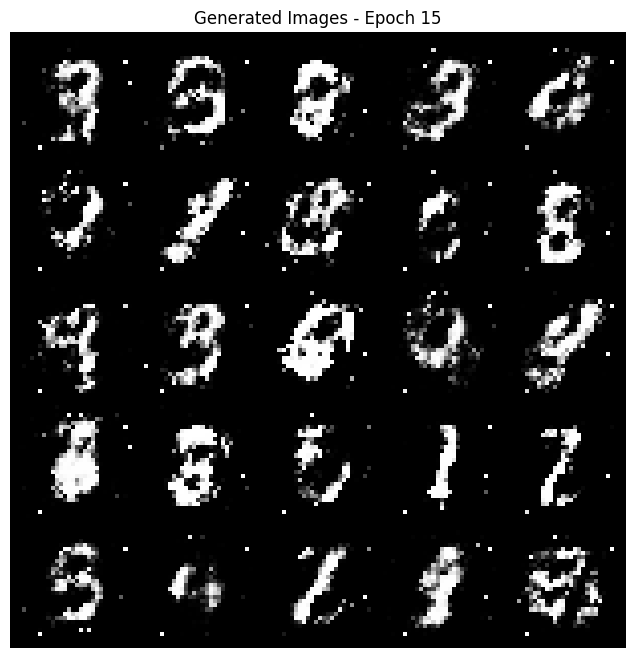

Epoch [15/20] completed - Avg D_loss: 1.5212, Avg G_loss: 0.9975
------------------------------------------------------------
Epoch [16/20], Batch [1/938], D_loss: 0.9586, G_loss: 1.6233, D(real): 0.6761, D(fake): 0.2734
Epoch [16/20], Batch [101/938], D_loss: 0.9087, G_loss: 1.3839, D(real): 0.6435, D(fake): 0.2474
Epoch [16/20], Batch [201/938], D_loss: 1.1062, G_loss: 1.3092, D(real): 0.5652, D(fake): 0.2561
Epoch [16/20], Batch [301/938], D_loss: 0.9470, G_loss: 1.7476, D(real): 0.6509, D(fake): 0.2506
Epoch [16/20], Batch [401/938], D_loss: 0.9943, G_loss: 1.9465, D(real): 0.6849, D(fake): 0.3264
Epoch [16/20], Batch [501/938], D_loss: 1.0100, G_loss: 1.8502, D(real): 0.6741, D(fake): 0.2870
Epoch [16/20], Batch [601/938], D_loss: 0.9744, G_loss: 1.6687, D(real): 0.7061, D(fake): 0.3410
Epoch [16/20], Batch [701/938], D_loss: 0.9139, G_loss: 1.9038, D(real): 0.7041, D(fake): 0.2940
Epoch [16/20], Batch [801/938], D_loss: 0.9747, G_loss: 1.3995, D(real): 0.6023, D(fake): 0.2474
Epo

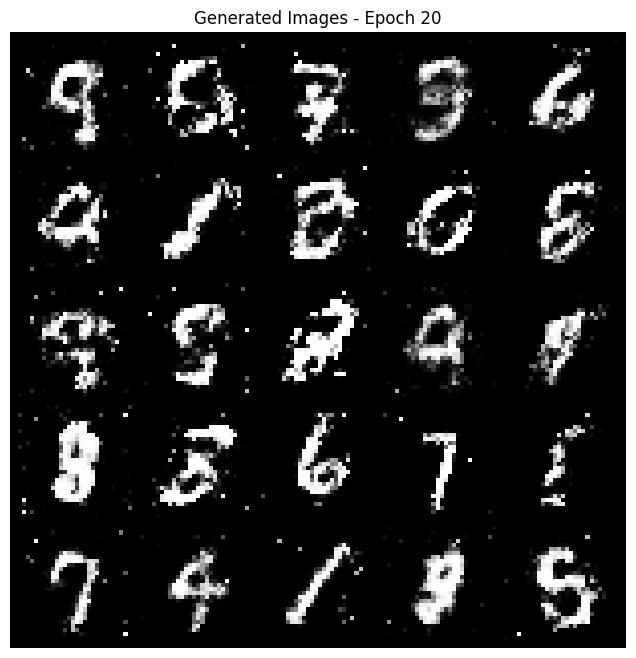

Epoch [20/20] completed - Avg D_loss: 1.3619, Avg G_loss: 1.0737
------------------------------------------------------------
Training completed!


In [7]:

# ============================================================================
# 4. TRAINING LOOP
# ============================================================================

def save_sample_images(generator, noise, epoch, num_images=25):
    """Generate and save sample images"""
    generator.eval()
    with torch.no_grad():
        fake_images = generator(noise)
        fake_images = (fake_images + 1) / 2  # Denormalize to [0, 1]

        # Create grid
        grid = make_grid(fake_images, nrow=5, normalize=False, padding=2)

        # Plot
        plt.figure(figsize=(8, 8))
        plt.imshow(grid.permute(1, 2, 0).cpu())
        plt.title(f'Generated Images - Epoch {epoch}')
        plt.axis('off')
        plt.show()

    generator.train()

print("Starting training...")
print("-" * 60)

for epoch in range(num_epochs):
    epoch_D_loss = 0
    epoch_G_loss = 0
    epoch_D_real = 0
    epoch_D_fake = 0

    for i, (real_images, _) in enumerate(dataloader):
        batch_size = real_images.size(0)
        real_images = real_images.to(device)

        # Create labels
        real_labels = torch.full((batch_size, 1), real_label_value, device=device)
        fake_labels = torch.full((batch_size, 1), 0.0, device=device)

        # ====================================
        # Train Discriminator
        # ====================================
        optimizer_D.zero_grad()

        # Real images
        output_real = discriminator(real_images)
        loss_D_real = criterion(output_real, real_labels)

        # Fake images
        noise = torch.randn(batch_size, noise_dim, device=device)
        fake_images = generator(noise)
        output_fake = discriminator(fake_images.detach())  # Detach to avoid training G
        loss_D_fake = criterion(output_fake, fake_labels)

        # Total discriminator loss
        loss_D = loss_D_real + loss_D_fake
        loss_D.backward()
        optimizer_D.step()

        # ====================================
        # Train Generator
        # ====================================
        optimizer_G.zero_grad()

        # Generate fake images and get discriminator's opinion
        output_fake_for_G = discriminator(fake_images)
        loss_G = criterion(output_fake_for_G, real_labels)  # Want D to classify fake as real

        loss_G.backward()
        optimizer_G.step()

        # ====================================
        # Record statistics
        # ====================================
        epoch_D_loss += loss_D.item()
        epoch_G_loss += loss_G.item()
        epoch_D_real += output_real.mean().item()
        epoch_D_fake += output_fake.mean().item()

        # Print progress
        if i % print_interval == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}/{len(dataloader)}], '
                  f'D_loss: {loss_D.item():.4f}, G_loss: {loss_G.item():.4f}, '
                  f'D(real): {output_real.mean().item():.4f}, D(fake): {output_fake.mean().item():.4f}')

    # Record epoch averages
    G_losses.append(epoch_G_loss / len(dataloader))
    D_losses.append(epoch_D_loss / len(dataloader))
    D_real_scores.append(epoch_D_real / len(dataloader))
    D_fake_scores.append(epoch_D_fake / len(dataloader))

    # Save sample images every few epochs
    if (epoch + 1) % save_interval == 0 or epoch == 0:
        print(f"\nGenerating sample images for epoch {epoch+1}...")
        save_sample_images(generator, fixed_noise, epoch+1)

    print(f'Epoch [{epoch+1}/{num_epochs}] completed - '
          f'Avg D_loss: {G_losses[-1]:.4f}, Avg G_loss: {D_losses[-1]:.4f}')
    print("-" * 60)

print("Training completed!")


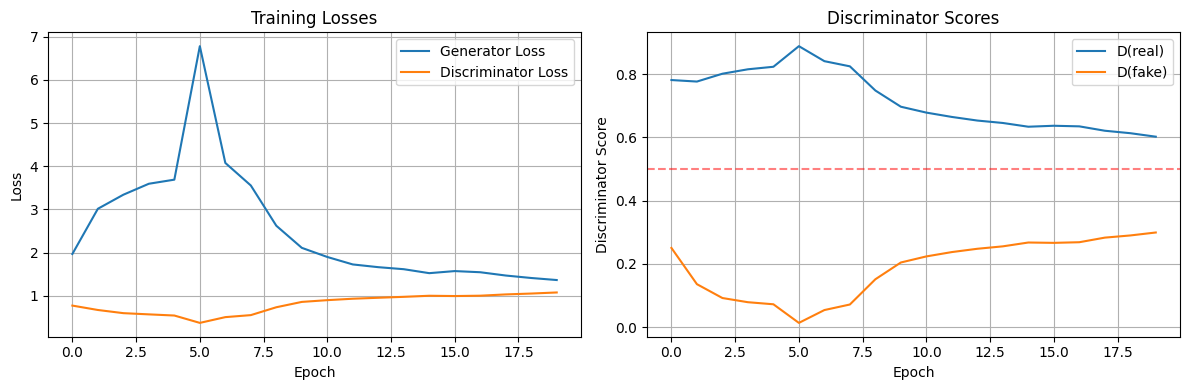


Final generated images:


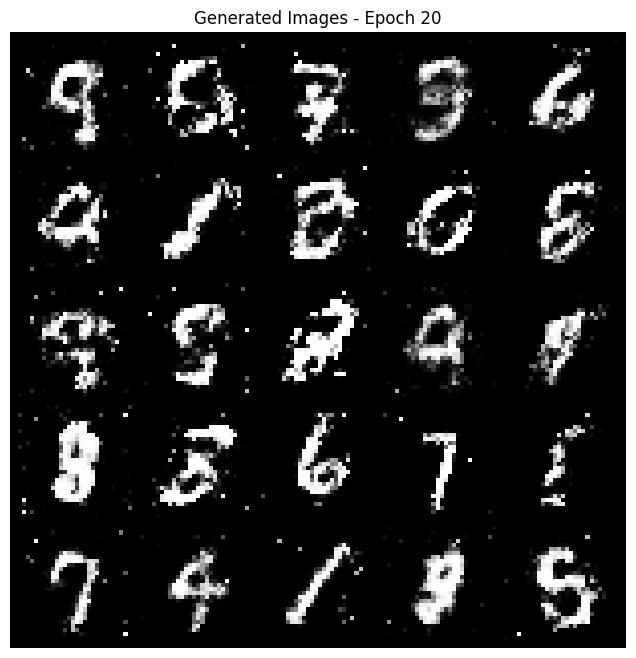


Generated images with different random noise:


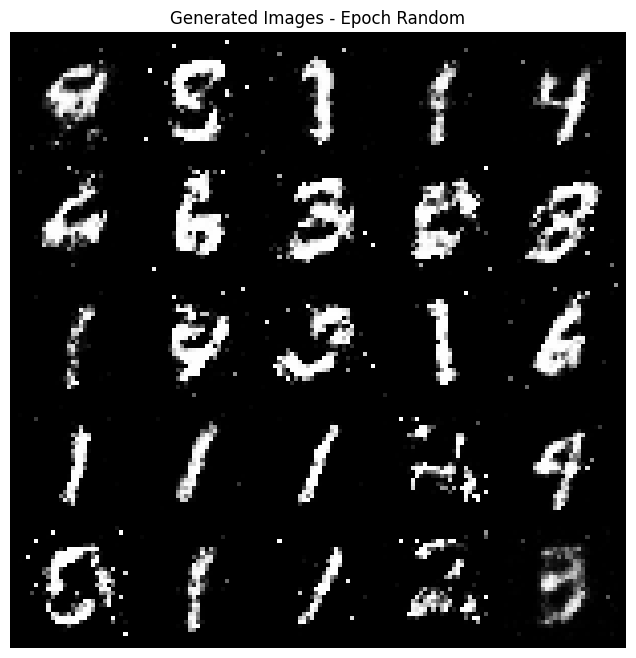

In [8]:

# ============================================================================
# 5. RESULTS AND VISUALIZATION
# ============================================================================

# Plot loss curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(G_losses, label='Generator Loss')
plt.plot(D_losses, label='Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(D_real_scores, label='D(real)')
plt.plot(D_fake_scores, label='D(fake)')
plt.xlabel('Epoch')
plt.ylabel('Discriminator Score')
plt.title('Discriminator Scores')
plt.legend()
plt.grid(True)
plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label='Ideal equilibrium')

plt.tight_layout()
plt.show()

# Generate final sample images
print("\nFinal generated images:")
save_sample_images(generator, fixed_noise, num_epochs)

# Generate diverse images with different noise
print("\nGenerated images with different random noise:")
random_noise = torch.randn(25, noise_dim, device=device)
save_sample_images(generator, random_noise, "Random")



Training Statistics Summary:
Final Generator Loss: 1.3619
Final Discriminator Loss: 1.0737
Final D(real) score: 0.6022
Final D(fake) score: 0.2991
Generator-Discriminator difference: 0.3031


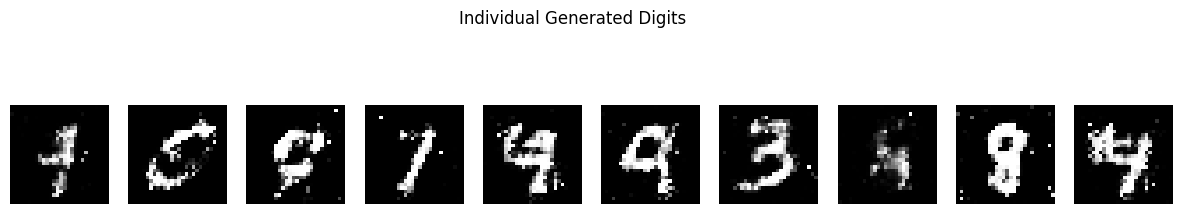

In [9]:

# ============================================================================
# 6. MODEL EVALUATION AND ANALYSIS
# ============================================================================

def generate_images(num_images=100):
    """Generate a batch of images for analysis"""
    generator.eval()
    with torch.no_grad():
        noise = torch.randn(num_images, noise_dim, device=device)
        generated_images = generator(noise)
        generated_images = (generated_images + 1) / 2  # Denormalize
    generator.train()
    return generated_images

# Generate images for analysis
sample_images = generate_images(50)

# Display some statistics
print("\nTraining Statistics Summary:")
print(f"Final Generator Loss: {G_losses[-1]:.4f}")
print(f"Final Discriminator Loss: {D_losses[-1]:.4f}")
print(f"Final D(real) score: {D_real_scores[-1]:.4f}")
print(f"Final D(fake) score: {D_fake_scores[-1]:.4f}")
print(f"Generator-Discriminator difference: {abs(D_real_scores[-1] - D_fake_scores[-1]):.4f}")

# Show some individual generated digits
plt.figure(figsize=(15, 3))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(sample_images[i].squeeze().cpu(), cmap='gray')
    plt.axis('off')
plt.suptitle('Individual Generated Digits')
plt.show()

print("\n" + "="*80)


---

In [10]:
# ============================================================================
# TASK 3.2: EXPERIMENTING WITH TRAINING ISSUES
# ============================================================================


print("TASK 3.2: EXPERIMENTING WITH TRAINING ISSUES")
print("="*80)

# Helper function to reset models
def reset_models():
    """Reset both generator and discriminator to initial state"""
    generator = Generator(noise_dim).to(device)
    discriminator = Discriminator().to(device)
    return generator, discriminator

# Helper function for training with custom parameters
def train_gan_experiment(gen, disc, dataloader, num_epochs, lr_g, lr_d,
                        d_steps=1, g_steps=1, label_smoothing_val=1.0,
                        non_saturating=True, experiment_name="Experiment"):
    """
    Train GAN with custom parameters for experiments
    """
    criterion = nn.BCELoss()
    optimizer_G = optim.Adam(gen.parameters(), lr=lr_g, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(disc.parameters(), lr=lr_d, betas=(0.5, 0.999))

    G_losses = []
    D_losses = []
    D_real_scores = []
    D_fake_scores = []

    print(f"\n{experiment_name} - Training Parameters:")
    print(f"Generator LR: {lr_g}, Discriminator LR: {lr_d}")
    print(f"D steps per G step: {d_steps}, Label smoothing: {label_smoothing_val}")
    print(f"Non-saturating loss: {non_saturating}")

    for epoch in range(num_epochs):
        epoch_D_loss = 0
        epoch_G_loss = 0
        epoch_D_real = 0
        epoch_D_fake = 0
        batch_count = 0

        for i, (real_images, _) in enumerate(dataloader):
            batch_size = real_images.size(0)
            real_images = real_images.to(device)
            batch_count += 1

            # Create labels
            real_labels = torch.full((batch_size, 1), label_smoothing_val, device=device)
            fake_labels = torch.full((batch_size, 1), 0.0, device=device)

            # Train Discriminator (potentially multiple steps)
            d_loss_total = 0
            d_real_total = 0
            d_fake_total = 0

            for _ in range(d_steps):
                optimizer_D.zero_grad()

                # Real images
                output_real = disc(real_images)
                loss_D_real = criterion(output_real, real_labels)

                # Fake images
                noise = torch.randn(batch_size, noise_dim, device=device)
                fake_images = gen(noise)
                output_fake = disc(fake_images.detach())
                loss_D_fake = criterion(output_fake, fake_labels)

                loss_D = loss_D_real + loss_D_fake
                loss_D.backward()
                optimizer_D.step()

                d_loss_total += loss_D.item()
                d_real_total += output_real.mean().item()
                d_fake_total += output_fake.mean().item()

            # Train Generator (potentially multiple steps)
            g_loss_total = 0
            for _ in range(g_steps):
                optimizer_G.zero_grad()

                noise = torch.randn(batch_size, noise_dim, device=device)
                fake_images = gen(noise)
                output_fake_for_G = disc(fake_images)

                if non_saturating:
                    # Non-saturating loss: maximize log(D(G(z)))
                    loss_G = criterion(output_fake_for_G, real_labels)
                else:
                    # Original minimax loss: minimize log(1 - D(G(z)))
                    loss_G = criterion(output_fake_for_G, fake_labels)
                    loss_G = -loss_G  # Minimize negative = maximize original

                loss_G.backward()
                optimizer_G.step()
                g_loss_total += loss_G.item()

            # Record statistics (averaged over multiple steps)
            epoch_D_loss += d_loss_total / d_steps
            epoch_G_loss += g_loss_total / g_steps
            epoch_D_real += d_real_total / d_steps
            epoch_D_fake += d_fake_total / d_steps

        # Record epoch averages
        G_losses.append(epoch_G_loss / batch_count)
        D_losses.append(epoch_D_loss / batch_count)
        D_real_scores.append(epoch_D_real / batch_count)
        D_fake_scores.append(epoch_D_fake / batch_count)

        if epoch % 5 == 0 or epoch == num_epochs - 1:
            print(f'Epoch [{epoch+1}/{num_epochs}] - '
                  f'D_loss: {D_losses[-1]:.4f}, G_loss: {G_losses[-1]:.4f}, '
                  f'D(real): {D_real_scores[-1]:.4f}, D(fake): {D_fake_scores[-1]:.4f}')

    return G_losses, D_losses, D_real_scores, D_fake_scores

# Helper function to evaluate diversity
def evaluate_diversity(generator, num_samples=100):
    """Evaluate diversity of generated samples"""
    generator.eval()
    with torch.no_grad():
        noise = torch.randn(num_samples, noise_dim, device=device)
        samples = generator(noise)
        samples = samples.view(num_samples, -1).cpu().numpy()

        # Calculate variance across samples
        sample_variance = np.var(samples, axis=0).mean()

        # Calculate pairwise distances
        from scipy.spatial.distance import pdist
        distances = pdist(samples, metric='euclidean')
        mean_distance = np.mean(distances)

    generator.train()
    return sample_variance, mean_distance


TASK 3.2: EXPERIMENTING WITH TRAINING ISSUES



EXPERIMENT 1: GRADIENT VANISHING

1.1: Inducing Gradient Vanishing (Strong Discriminator)
--------------------------------------------------

Gradient Vanishing (Strong D) - Training Parameters:
Generator LR: 0.0002, Discriminator LR: 0.002
D steps per G step: 3, Label smoothing: 1.0
Non-saturating loss: False
Epoch [1/15] - D_loss: 5.6203, G_loss: -5.5253, D(real): 0.9781, D(fake): 0.1008
Epoch [6/15] - D_loss: 100.0000, G_loss: -100.0000, D(real): 1.0000, D(fake): 1.0000
Epoch [11/15] - D_loss: 100.0000, G_loss: -100.0000, D(real): 1.0000, D(fake): 1.0000
Epoch [15/15] - D_loss: 100.0000, G_loss: -100.0000, D(real): 1.0000, D(fake): 1.0000

Generating samples from gradient-vanished generator:


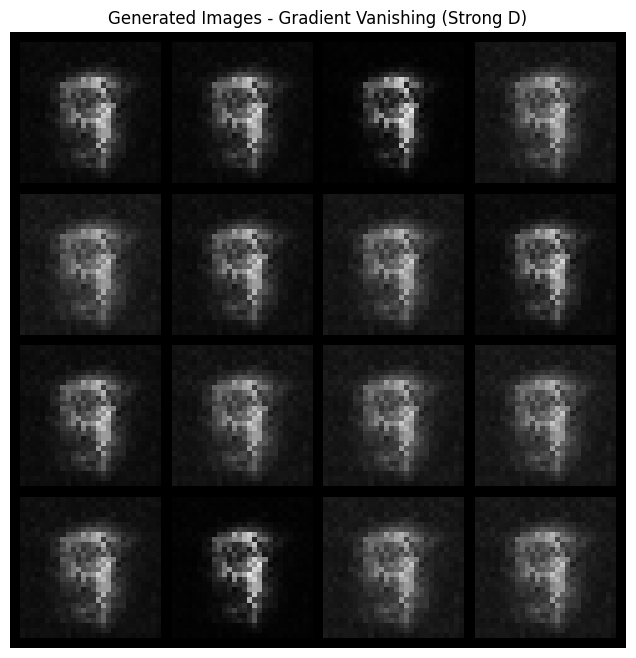


1.2: Mitigating Gradient Vanishing
--------------------------------------------------

Gradient Vanishing Mitigation - Training Parameters:
Generator LR: 0.0002, Discriminator LR: 0.0002
D steps per G step: 1, Label smoothing: 0.9
Non-saturating loss: True
Epoch [1/15] - D_loss: 0.8231, G_loss: 1.7557, D(real): 0.7641, D(fake): 0.2771
Epoch [6/15] - D_loss: 0.8665, G_loss: 1.9569, D(real): 0.6953, D(fake): 0.2087
Epoch [11/15] - D_loss: 1.0188, G_loss: 1.4426, D(real): 0.6248, D(fake): 0.2781
Epoch [15/15] - D_loss: 1.1199, G_loss: 1.2231, D(real): 0.5804, D(fake): 0.3212

Generating samples after gradient vanishing mitigation:


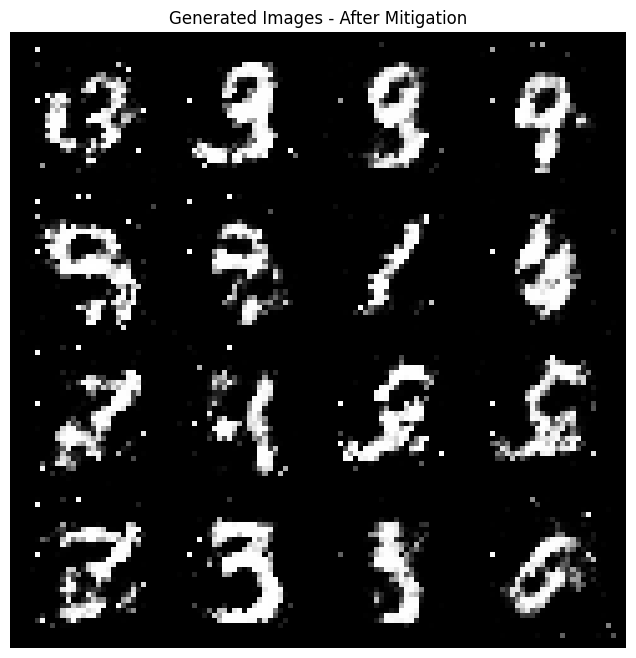

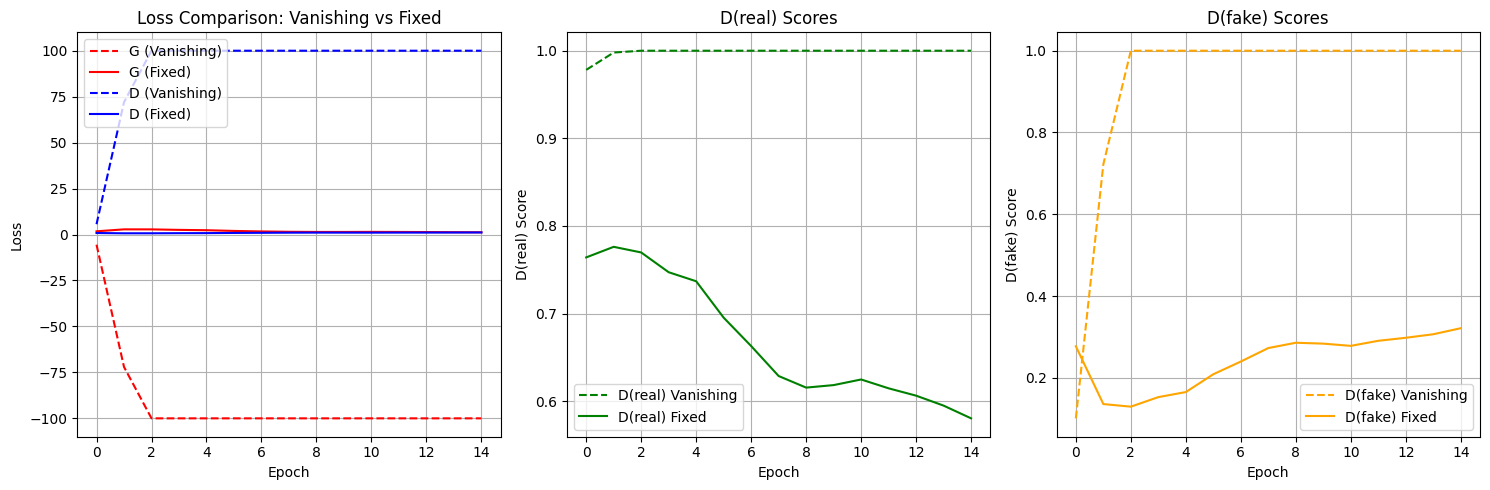

In [11]:

# ============================================================================
# EXPERIMENT 1: GRADIENT VANISHING
# ============================================================================

print("\n" + "="*60)
print("EXPERIMENT 1: GRADIENT VANISHING")
print("="*60)

# Reset models for experiment 1
gen_exp1, disc_exp1 = reset_models()

print("\n1.1: Inducing Gradient Vanishing (Strong Discriminator)")
print("-" * 50)

# Setup: Make D much stronger by increasing its learning rate
lr_g_weak = 2e-4
lr_d_strong = 2e-3  # 10x higher learning rate for D

# Train with strong discriminator
G_losses_vanish, D_losses_vanish, D_real_vanish, D_fake_vanish = train_gan_experiment(
    gen_exp1, disc_exp1, dataloader, num_epochs=15,
    lr_g=lr_g_weak, lr_d=lr_d_strong,
    d_steps=3, g_steps=1,  # Train D 3 times per G step
    label_smoothing_val=1.0,  # No smoothing initially
    non_saturating=False,  # Use original minimax loss
    experiment_name="Gradient Vanishing (Strong D)"
)

# Generate samples to show poor quality
print("\nGenerating samples from gradient-vanished generator:")
fixed_noise_exp = torch.randn(16, noise_dim, device=device)
gen_exp1.eval()
with torch.no_grad():
    vanish_samples = gen_exp1(fixed_noise_exp)
    vanish_samples = (vanish_samples + 1) / 2
gen_exp1.train()

plt.figure(figsize=(8, 8))
grid = make_grid(vanish_samples, nrow=4, normalize=False, padding=2)
plt.imshow(grid.permute(1, 2, 0).cpu())
plt.title('Generated Images - Gradient Vanishing (Strong D)')
plt.axis('off')
plt.show()

print("\n1.2: Mitigating Gradient Vanishing")
print("-" * 50)

# Reset models for mitigation
gen_exp1_fix, disc_exp1_fix = reset_models()

# Apply mitigation: label smoothing + non-saturating loss + balanced training
G_losses_fixed, D_losses_fixed, D_real_fixed, D_fake_fixed = train_gan_experiment(
    gen_exp1_fix, disc_exp1_fix, dataloader, num_epochs=15,
    lr_g=2e-4, lr_d=2e-4,  # Equal learning rates
    d_steps=1, g_steps=1,  # Balanced training
    label_smoothing_val=0.9,  # Label smoothing
    non_saturating=True,  # Non-saturating loss
    experiment_name="Gradient Vanishing Mitigation"
)

# Generate samples after mitigation
print("\nGenerating samples after gradient vanishing mitigation:")
gen_exp1_fix.eval()
with torch.no_grad():
    fixed_samples = gen_exp1_fix(fixed_noise_exp)
    fixed_samples = (fixed_samples + 1) / 2
gen_exp1_fix.train()

plt.figure(figsize=(8, 8))
grid = make_grid(fixed_samples, nrow=4, normalize=False, padding=2)
plt.imshow(grid.permute(1, 2, 0).cpu())
plt.title('Generated Images - After Mitigation')
plt.axis('off')
plt.show()

# Plot comparison
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(G_losses_vanish, label='G (Vanishing)', color='red', linestyle='--')
plt.plot(G_losses_fixed, label='G (Fixed)', color='red')
plt.plot(D_losses_vanish, label='D (Vanishing)', color='blue', linestyle='--')
plt.plot(D_losses_fixed, label='D (Fixed)', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Comparison: Vanishing vs Fixed')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(D_real_vanish, label='D(real) Vanishing', color='green', linestyle='--')
plt.plot(D_real_fixed, label='D(real) Fixed', color='green')
plt.xlabel('Epoch')
plt.ylabel('D(real) Score')
plt.title('D(real) Scores')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(D_fake_vanish, label='D(fake) Vanishing', color='orange', linestyle='--')
plt.plot(D_fake_fixed, label='D(fake) Fixed', color='orange')
plt.xlabel('Epoch')
plt.ylabel('D(fake) Score')
plt.title('D(fake) Scores')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()



EXPERIMENT 2: MODE COLLAPSE

2.1: Inducing Mode Collapse (Strong Generator)
--------------------------------------------------

Mode Collapse (Strong G) - Training Parameters:
Generator LR: 0.002, Discriminator LR: 0.0002
D steps per G step: 1, Label smoothing: 1.0
Non-saturating loss: True
Epoch [1/20] - D_loss: 1.3920, G_loss: 0.6849, D(real): 0.5048, D(fake): 0.5069
Epoch [6/20] - D_loss: 0.0000, G_loss: 16.7734, D(real): 1.0000, D(fake): 0.0000
Epoch [11/20] - D_loss: 0.0000, G_loss: 22.0079, D(real): 1.0000, D(fake): 0.0000
Epoch [16/20] - D_loss: 0.0000, G_loss: 34.5801, D(real): 1.0000, D(fake): 0.0000
Epoch [20/20] - D_loss: 0.0001, G_loss: 16.3703, D(real): 0.9999, D(fake): 0.0000
Diversity metrics (mode collapsed): Variance=0.000000, Mean Distance=0.0000

Generating samples to demonstrate mode collapse:


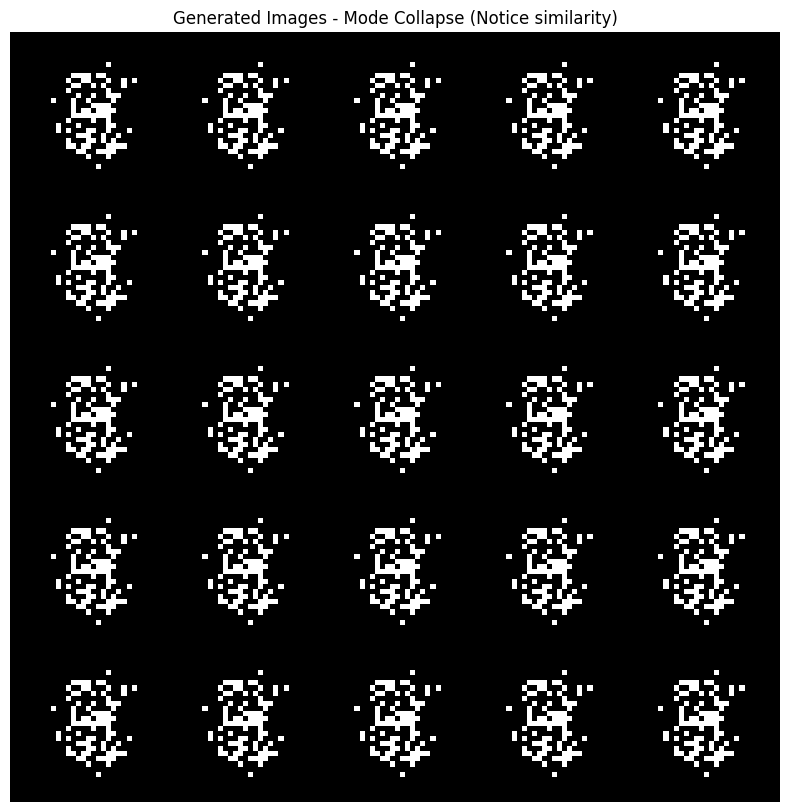


2.2: Mitigating Mode Collapse
--------------------------------------------------

Mode Collapse Mitigation (Strong D) - Training Parameters:
Generator LR: 0.0002, Discriminator LR: 0.0004
D steps per G step: 2, Label smoothing: 0.9
Non-saturating loss: True
Epoch [1/20] - D_loss: 0.5097, G_loss: 3.5760, D(real): 0.8583, D(fake): 0.0888
Epoch [6/20] - D_loss: 0.7193, G_loss: 2.3965, D(real): 0.7629, D(fake): 0.1395
Epoch [11/20] - D_loss: 0.8805, G_loss: 1.8350, D(real): 0.6941, D(fake): 0.2082
Epoch [16/20] - D_loss: 0.9870, G_loss: 1.5335, D(real): 0.6449, D(fake): 0.2577
Epoch [20/20] - D_loss: 1.0399, G_loss: 1.3970, D(real): 0.6205, D(fake): 0.2819
Diversity metrics (recovered): Variance=0.260795, Mean Distance=20.1521

Generating samples after mode collapse mitigation:


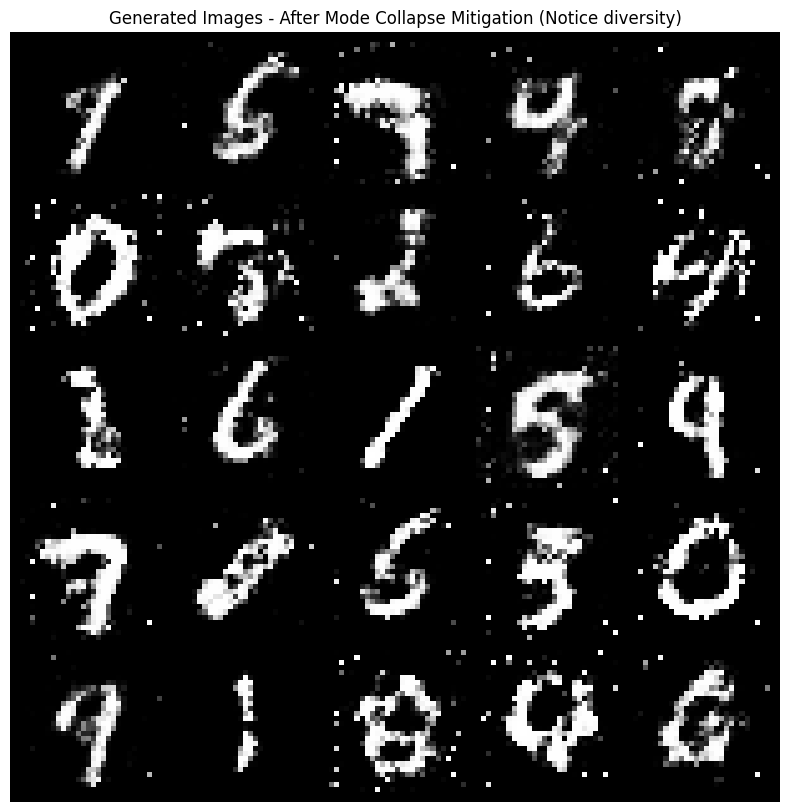

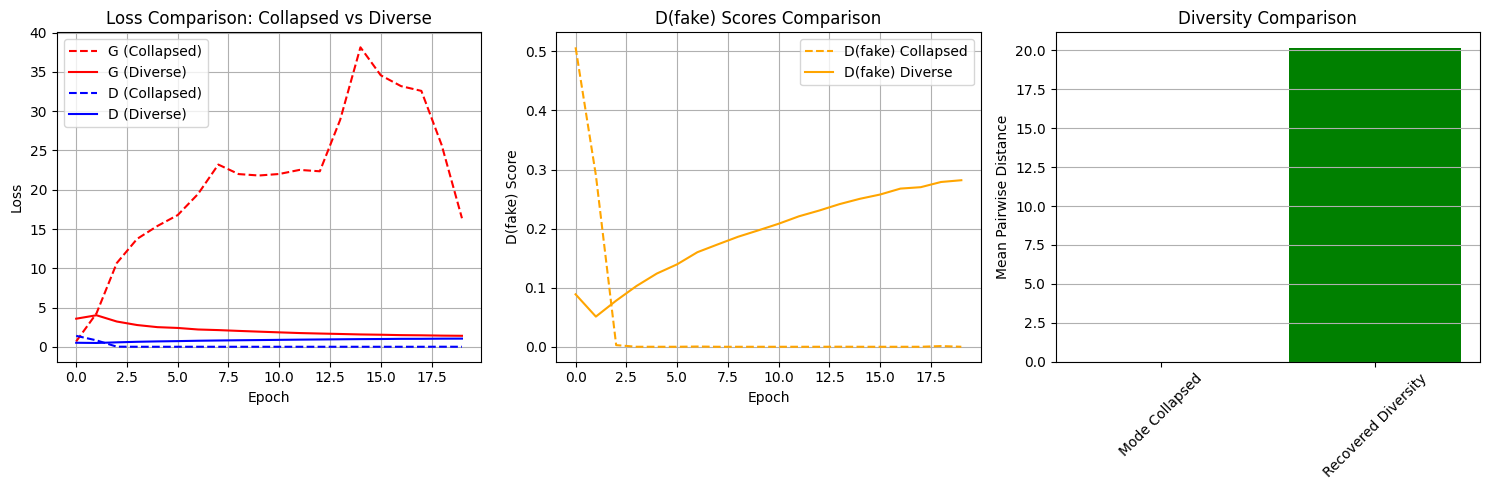

In [12]:

# ============================================================================
# EXPERIMENT 2: MODE COLLAPSE
# ============================================================================

print("\n" + "="*60)
print("EXPERIMENT 2: MODE COLLAPSE")
print("="*60)

print("\n2.1: Inducing Mode Collapse (Strong Generator)")
print("-" * 50)

# Reset models for experiment 2
gen_exp2, disc_exp2 = reset_models()

# Setup: Make G much stronger by increasing its learning rate
lr_g_strong = 2e-3  # 10x higher learning rate for G
lr_d_weak = 2e-4

# Train with strong generator to induce mode collapse
G_losses_collapse, D_losses_collapse, D_real_collapse, D_fake_collapse = train_gan_experiment(
    gen_exp2, disc_exp2, dataloader, num_epochs=20,
    lr_g=lr_g_strong, lr_d=lr_d_weak,
    d_steps=1, g_steps=3,  # Train G 3 times per D step
    label_smoothing_val=1.0,
    non_saturating=True,
    experiment_name="Mode Collapse (Strong G)"
)

# Evaluate diversity before collapse
diversity_before = evaluate_diversity(gen_exp2, num_samples=50)
print(f"Diversity metrics (mode collapsed): Variance={diversity_before[0]:.6f}, Mean Distance={diversity_before[1]:.4f}")

# Generate samples to show mode collapse
print("\nGenerating samples to demonstrate mode collapse:")
collapse_noise = torch.randn(25, noise_dim, device=device)
gen_exp2.eval()
with torch.no_grad():
    collapse_samples = gen_exp2(collapse_noise)
    collapse_samples = (collapse_samples + 1) / 2
gen_exp2.train()

plt.figure(figsize=(10, 10))
grid = make_grid(collapse_samples, nrow=5, normalize=False, padding=2)
plt.imshow(grid.permute(1, 2, 0).cpu())
plt.title('Generated Images - Mode Collapse (Notice similarity)')
plt.axis('off')
plt.show()

print("\n2.2: Mitigating Mode Collapse")
print("-" * 50)

# Reset models for mitigation
gen_exp2_fix, disc_exp2_fix = reset_models()

# Apply mitigation: stronger discriminator, balanced training
G_losses_diverse, D_losses_diverse, D_real_diverse, D_fake_diverse = train_gan_experiment(
    gen_exp2_fix, disc_exp2_fix, dataloader, num_epochs=20,
    lr_g=2e-4, lr_d=4e-4,  # Stronger D learning rate
    d_steps=2, g_steps=1,  # Train D twice per G step
    label_smoothing_val=0.9,
    non_saturating=True,
    experiment_name="Mode Collapse Mitigation (Strong D)"
)

# Evaluate diversity after mitigation
diversity_after = evaluate_diversity(gen_exp2_fix, num_samples=50)
print(f"Diversity metrics (recovered): Variance={diversity_after[0]:.6f}, Mean Distance={diversity_after[1]:.4f}")

# Generate samples after mitigation
print("\nGenerating samples after mode collapse mitigation:")
gen_exp2_fix.eval()
with torch.no_grad():
    diverse_samples = gen_exp2_fix(collapse_noise)  # Same noise for comparison
    diverse_samples = (diverse_samples + 1) / 2
gen_exp2_fix.train()

plt.figure(figsize=(10, 10))
grid = make_grid(diverse_samples, nrow=5, normalize=False, padding=2)
plt.imshow(grid.permute(1, 2, 0).cpu())
plt.title('Generated Images - After Mode Collapse Mitigation (Notice diversity)')
plt.axis('off')
plt.show()

# Plot mode collapse comparison
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(G_losses_collapse, label='G (Collapsed)', color='red', linestyle='--')
plt.plot(G_losses_diverse, label='G (Diverse)', color='red')
plt.plot(D_losses_collapse, label='D (Collapsed)', color='blue', linestyle='--')
plt.plot(D_losses_diverse, label='D (Diverse)', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Comparison: Collapsed vs Diverse')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
epochs = range(len(D_fake_collapse))
plt.plot(epochs, D_fake_collapse, label='D(fake) Collapsed', color='orange', linestyle='--')
plt.plot(range(len(D_fake_diverse)), D_fake_diverse, label='D(fake) Diverse', color='orange')
plt.xlabel('Epoch')
plt.ylabel('D(fake) Score')
plt.title('D(fake) Scores Comparison')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
diversity_comparison = [diversity_before[1], diversity_after[1]]
labels = ['Mode Collapsed', 'Recovered Diversity']
plt.bar(labels, diversity_comparison, color=['red', 'green'])
plt.ylabel('Mean Pairwise Distance')
plt.title('Diversity Comparison')
plt.xticks(rotation=45)
plt.grid(True, axis='y')

plt.tight_layout()
plt.show()



EXPERIMENT 3: DISCRIMINATOR OVERFITTING

3.1: Creating Limited Dataset
--------------------------------------------------
Limited training set: 1000 samples
Test set: 1000 samples

3.2: Inducing Discriminator Overfitting
--------------------------------------------------
Larger Discriminator parameters: 828929

Discriminator Overfitting (Limited Data) - Training Parameters:
Generator LR: 0.0002, Discriminator LR: 0.0002
D steps per G step: 1, Label smoothing: 1.0
Non-saturating loss: True
Epoch [1/25] - D_loss: 1.1862, G_loss: 0.6351, D(real): 0.6763, D(fake): 0.5312
Epoch [6/25] - D_loss: 1.2223, G_loss: 0.8330, D(real): 0.6047, D(fake): 0.4879
Epoch [11/25] - D_loss: 0.8770, G_loss: 1.1979, D(real): 0.8840, D(fake): 0.4799
Epoch [16/25] - D_loss: 0.7130, G_loss: 2.3537, D(real): 0.8736, D(fake): 0.3158
Epoch [21/25] - D_loss: 0.5037, G_loss: 3.7033, D(real): 0.8553, D(fake): 0.2026
Epoch [25/25] - D_loss: 0.2255, G_loss: 5.0980, D(real): 0.9453, D(fake): 0.0862

Discriminator perfor

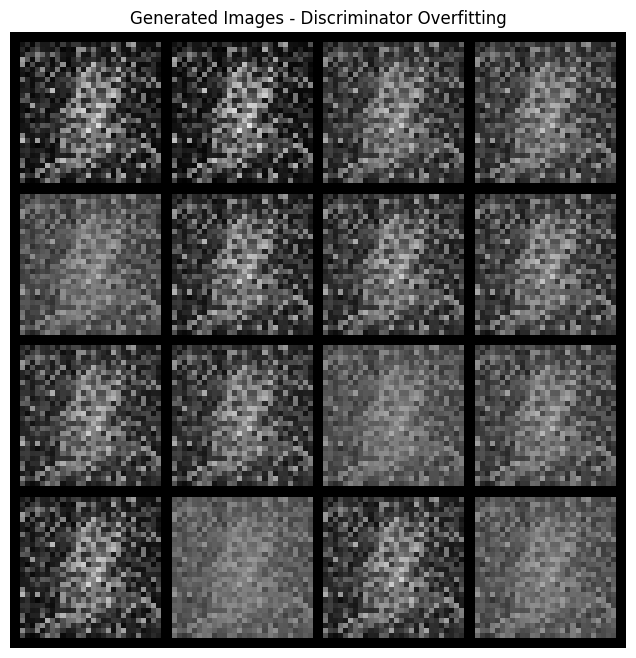


3.3: Mitigating Discriminator Overfitting
--------------------------------------------------

Overfitting Mitigation (Regularized D) - Training Parameters:
Generator LR: 0.0002, Discriminator LR: 0.0002
D steps per G step: 1, Label smoothing: 0.9
Non-saturating loss: True
Epoch [1/25] - D_loss: 1.1979, G_loss: 0.6645, D(real): 0.7093, D(fake): 0.5201
Epoch [6/25] - D_loss: 1.3565, G_loss: 0.7164, D(real): 0.5360, D(fake): 0.5097
Epoch [11/25] - D_loss: 1.1188, G_loss: 0.9074, D(real): 0.7567, D(fake): 0.4980
Epoch [16/25] - D_loss: 1.1464, G_loss: 0.8338, D(real): 0.6661, D(fake): 0.4669
Epoch [21/25] - D_loss: 0.8247, G_loss: 1.3675, D(real): 0.7494, D(fake): 0.2921
Epoch [25/25] - D_loss: 0.7181, G_loss: 1.4974, D(real): 0.8296, D(fake): 0.2397

Regularized Discriminator performance on unseen test data:
Accuracy: 1.000
Mean D(real_test): 0.932

Generating samples after discriminator regularization:


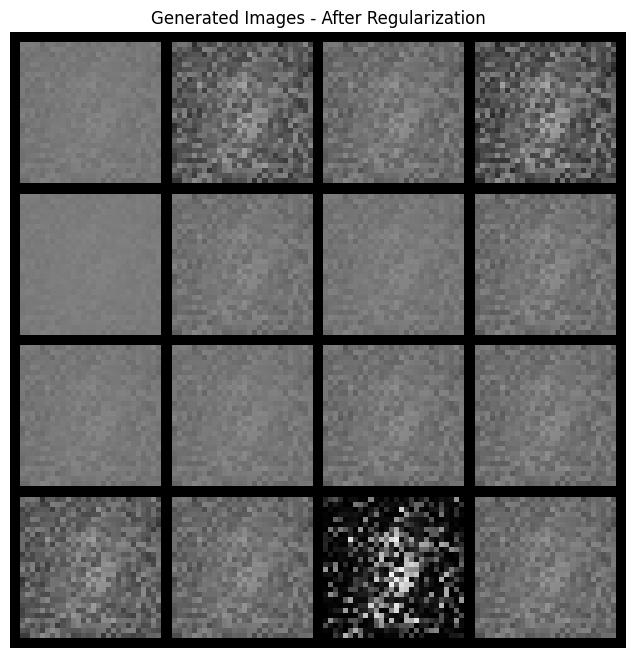

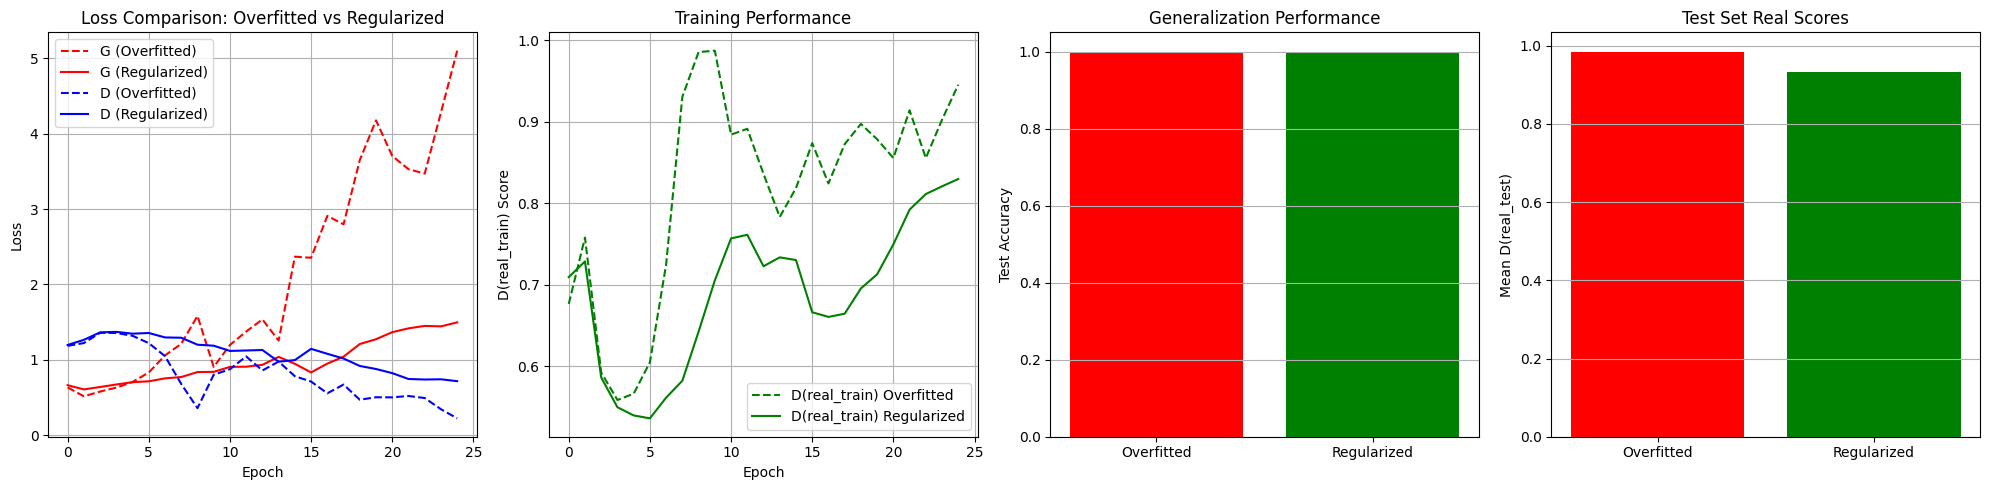

In [14]:

# ============================================================================
# EXPERIMENT 3: DISCRIMINATOR OVERFITTING
# ============================================================================

print("\n" + "="*60)
print("EXPERIMENT 3: DISCRIMINATOR OVERFITTING")
print("="*60)

print("\n3.1: Creating Limited Dataset")
print("-" * 50)

# Create a limited dataset (first 1000 samples)
limited_indices = list(range(1000))
limited_dataset = torch.utils.data.Subset(mnist_dataset, limited_indices)
limited_dataloader = DataLoader(limited_dataset, batch_size=64, shuffle=True)

# Create test set for evaluation (samples not in training)
test_indices = list(range(8000, 9000))  # 1000 samples for testing
test_dataset = torch.utils.data.Subset(mnist_dataset, test_indices)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"Limited training set: {len(limited_dataset)} samples")
print(f"Test set: {len(test_dataset)} samples")

print("\n3.2: Inducing Discriminator Overfitting")
print("-" * 50)

# Create a larger discriminator for overfitting
class OverfitDiscriminator(nn.Module):
    """Larger discriminator prone to overfitting"""
    def __init__(self, img_size=784):
        super(OverfitDiscriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(img_size, 512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(512, 512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(256, 128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(128, 1),
            nn.Sigmoid()
        )

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight.data, 0.0, 0.02)
                nn.init.constant_(m.bias.data, 0)

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity

# Reset models with larger discriminator
gen_exp3 = Generator(noise_dim).to(device)
disc_exp3 = OverfitDiscriminator().to(device)

print(f"Larger Discriminator parameters: {sum(p.numel() for p in disc_exp3.parameters())}")

# Train with limited data
G_losses_overfit, D_losses_overfit, D_real_overfit, D_fake_overfit = train_gan_experiment(
    gen_exp3, disc_exp3, limited_dataloader, num_epochs=25,
    lr_g=2e-4, lr_d=2e-4,
    d_steps=1, g_steps=1,
    label_smoothing_val=1.0,
    non_saturating=True,
    experiment_name="Discriminator Overfitting (Limited Data)"
)

# Evaluate discriminator on test set
def evaluate_discriminator_generalization(discriminator, test_loader):
    """Evaluate discriminator on unseen test data"""
    discriminator.eval()
    total_correct = 0
    total_samples = 0
    real_scores = []

    with torch.no_grad():
        for real_images, _ in test_loader:
            real_images = real_images.to(device)
            outputs = discriminator(real_images)
            real_scores.extend(outputs.cpu().numpy())

            # Consider > 0.5 as "real" prediction
            predicted = (outputs > 0.5).float()
            total_correct += predicted.sum().item()
            total_samples += real_images.size(0)

    accuracy = total_correct / total_samples
    mean_score = np.mean(real_scores)
    discriminator.train()

    return accuracy, mean_score, real_scores

test_accuracy, test_mean_score, test_scores = evaluate_discriminator_generalization(disc_exp3, test_dataloader)
print(f"\nDiscriminator performance on unseen test data:")
print(f"Accuracy: {test_accuracy:.3f}")
print(f"Mean D(real_test): {test_mean_score:.3f}")

# Generate samples from overfitted training
print("\nGenerating samples from overfitted discriminator training:")
gen_exp3.eval()
with torch.no_grad():
    overfit_samples = gen_exp3(fixed_noise_exp)
    overfit_samples = (overfit_samples + 1) / 2
gen_exp3.train()

plt.figure(figsize=(8, 8))
grid = make_grid(overfit_samples, nrow=4, normalize=False, padding=2)
plt.imshow(grid.permute(1, 2, 0).cpu())
plt.title('Generated Images - Discriminator Overfitting')
plt.axis('off')
plt.show()

print("\n3.3: Mitigating Discriminator Overfitting")
print("-" * 50)

# Create regularized discriminator
class RegularizedDiscriminator(nn.Module):
    """Discriminator with stronger regularization"""
    def __init__(self, img_size=784):
        super(RegularizedDiscriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(img_size, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5),  # Higher dropout

            nn.Linear(256, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5),  # Higher dropout

            nn.Linear(256, 1),
            nn.Sigmoid()
        )

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight.data, 0.0, 0.02)
                nn.init.constant_(m.bias.data, 0)

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity

# Reset models with regularized discriminator
gen_exp3_fix = Generator(noise_dim).to(device)
disc_exp3_fix = RegularizedDiscriminator().to(device)

# Train with regularization
G_losses_reg, D_losses_reg, D_real_reg, D_fake_reg = train_gan_experiment(
    gen_exp3_fix, disc_exp3_fix, limited_dataloader, num_epochs=25,
    lr_g=2e-4, lr_d=2e-4,
    d_steps=1, g_steps=1,
    label_smoothing_val=0.9,  # Also apply label smoothing
    non_saturating=True,
    experiment_name="Overfitting Mitigation (Regularized D)"
)

# Evaluate regularized discriminator on test set
test_accuracy_reg, test_mean_score_reg, test_scores_reg = evaluate_discriminator_generalization(disc_exp3_fix, test_dataloader)
print(f"\nRegularized Discriminator performance on unseen test data:")
print(f"Accuracy: {test_accuracy_reg:.3f}")
print(f"Mean D(real_test): {test_mean_score_reg:.3f}")

# Generate samples after regularization
print("\nGenerating samples after discriminator regularization:")
gen_exp3_fix.eval()
with torch.no_grad():
    reg_samples = gen_exp3_fix(fixed_noise_exp)
    reg_samples = (reg_samples + 1) / 2
gen_exp3_fix.train()

plt.figure(figsize=(8, 8))
grid = make_grid(reg_samples, nrow=4, normalize=False, padding=2)
plt.imshow(grid.permute(1, 2, 0).cpu())
plt.title('Generated Images - After Regularization')
plt.axis('off')
plt.show()

# Plot overfitting comparison
plt.figure(figsize=(20, 5))

plt.subplot(1, 4, 1)
plt.plot(G_losses_overfit, label='G (Overfitted)', color='red', linestyle='--')
plt.plot(G_losses_reg, label='G (Regularized)', color='red')
plt.plot(D_losses_overfit, label='D (Overfitted)', color='blue', linestyle='--')
plt.plot(D_losses_reg, label='D (Regularized)', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Comparison: Overfitted vs Regularized')
plt.legend()
plt.grid(True)

plt.subplot(1, 4, 2)
plt.plot(D_real_overfit, label='D(real_train) Overfitted', color='green', linestyle='--')
plt.plot(D_real_reg, label='D(real_train) Regularized', color='green')
plt.xlabel('Epoch')
plt.ylabel('D(real_train) Score')
plt.title('Training Performance')
plt.legend()
plt.grid(True)

plt.subplot(1, 4, 3)
test_comparison = [test_accuracy, test_accuracy_reg]
labels = ['Overfitted', 'Regularized']
plt.bar(labels, test_comparison, color=['red', 'green'])
plt.ylabel('Test Accuracy')
plt.title('Generalization Performance')
plt.grid(True, axis='y')

plt.subplot(1, 4, 4)
test_score_comparison = [test_mean_score, test_mean_score_reg]
plt.bar(labels, test_score_comparison, color=['red', 'green'])
plt.ylabel('Mean D(real_test)')
plt.title('Test Set Real Scores')
plt.grid(True, axis='y')

plt.tight_layout()
plt.show()

print("\n" + "="*80)